# **Chapter 02. Machine Learning Models**

### **實務範例一：花朵辨識**

* Google建立之 5-flowers 資料集有五種類型的花朵：daisy(雛菊)、dandelion(蒲公英)、roses(玫瑰)、sunflowers(向日葵)、tulips(鬱金香)，共3670張
* Source: gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/
* Training set: gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv
* Evaluation set: gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv

### 機器學習訓練經驗談
* 數量：要從頭訓練ML模型，通常需要搜集`數百萬`張影像
* 資料格式：將影像儲存成單獨的JPEG檔案會很沒效率（花費許多時間在讀取上），最好使用`TensorFlow Record`格式

##### 確認 GPU 狀況 (TensorFlow 只支援 NVIDIA 的 GPU, 並不支援蘋果的 AMD)

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.18.0
Found GPU at: /device:GPU:0


---
### **Step 0. Prerequisite**
##### 先來觀察 train_set.csv 的前五行。他們都是由 (JPEG filename, type of flower) 組成

In [4]:
!gsutil cat gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv | head -5

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy


In [5]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3    # 只讀取 (R, G, B) 三個 channels, 而不要第四 channel (opacity, 透明度)

def read_and_decode(filename, reshape_dims):
  img = tf.io.read_file(filename)                           # 1. 讀取檔案
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)    # 2. 將壓縮的字串轉為 3D uint8 tensor (RGB). 此時RGB的數值範圍為 [0, 255]
  img = tf.image.convert_image_dtype(img, tf.float32)       # 3. 將 3D uint8 轉為 [0, 1] 範圍間的浮點數 -> 因為ML通常更擅長處理小數值
  return tf.image.resize(img, reshape_dims)                 # 4. 調整影像成一致的大小

##### * PS: Tensor 是什麼？
* `Tensor 是任意維度的 array` (一維是vector, 二維是matrix)
* `numpy` 是 Python 最常用的 array 數學程式庫，可以用來建立n維陣列及其操作；但它一律都使用 `CPU` 進行運算！
* 所以必須轉換成 `TensorFlow tensor` 的格式才能得到 `GPU` 加速

In [6]:
# 確認花朵的類別
CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


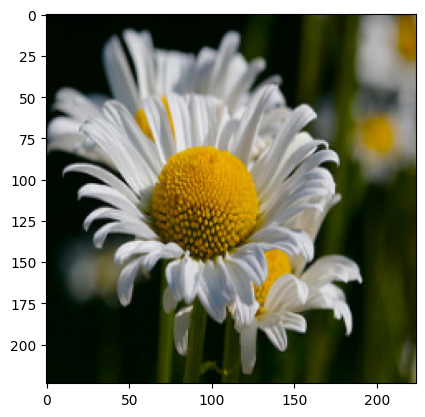

In [9]:
# 讀取其中一張圖片
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()))         # plt.imshow() 預期看到的是 numpy, 所以要從 tensor 轉換回 numpy

show_image("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


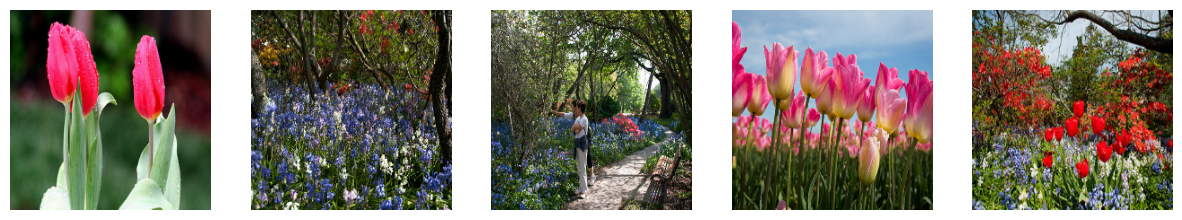

In [10]:
# 利用檔名來提取出所有 鬱金香(tulips) 的圖片, 並顯示出前五張
# glob() 函數可以用來進行匹配搜尋
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

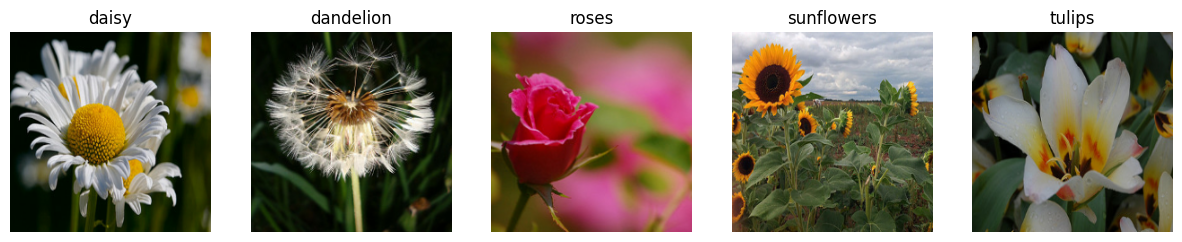

In [17]:
# 從檔名提取出花朵類別

def get_label(filename):
  basename = tf.strings.regex_replace(
      filename,
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")
  label = tf.strings.split(basename, '/')[0]
  label = label.numpy().decode('utf-8')               # 把 label 從 tensor 轉回 numpy
  return label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = get_label(filename)
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(label)
  ax[idx].axis('off')

In [24]:
# 將 csv 讀出的每一行文字 (filename, label) 切開，並透過 read_and_decode() 讀取圖片
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  return img, label_string

# 先用 TextLineDataset 逐行讀取 csv，再分別去進行 map() 裡的函數
dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv")
  .map(decode_csv))

# 印出圖片 RGB 三個 channels 的平均像素值
for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1])    # 因為影像維度是 [x, y, channel], 所以 axis=[0, 1] 代表指定計算每個 channel 當作獨立矩陣的平均值
  print(label.numpy().decode('utf-8'), '; avg =', avg)

daisy ; avg = tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
dandelion ; avg = tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
dandelion ; avg = tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


---
# **Approach \#1: 利用 RGB 的數值來判斷花朵種類**

In [28]:
# 計算出不同花的 RGB 平均值, 再試著從 input 的 RGB 數值分析出 最接近哪種花朵的質心(Centroid)

class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0

  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print('Count = 100 :', self.label)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {f: Centroid(f) for f in CLASS_NAMES}

  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf-8")
      avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
      self.centroids[label].update(avg)

  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    best_label = ""
    best_diff = 999
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = best_diff
        best_label = key
    return best_label

  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode('utf-8')
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

rule = CentroidRule()

In [29]:
# 來測試看看，先以 500 筆資料訓練
# to try it on the full dataset, remove the .take(500)
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).take(500)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).take(50)

rule.fit(train_dataset)

# 其實各種花的RGB值沒有太多的差異！以 daisy 與 roses 為例：
print('Centroid of Daisy:', rule.centroids['daisy'])
print('Centroid of Roses:', rule.centroids['roses'])

# 計算 Accuracy，會發現準確率極低
print('Accuracy:', rule.evaluate(eval_dataset))

Count = 100 : dandelion
Count = 100 : tulips
Centroid of Daisy: daisy [0.44554377 0.44968468 0.3594977 ]
Centroid of Roses: roses [0.46776444 0.37675467 0.31471127]
Accuracy: 0.24


In [30]:
# 嘗試做預測，當然會失敗
filename = "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
pred = rule.predict(img)
print(pred)

tulips


---
# **Approach \#2: 使用 Keras 的線性模型(Linear Model)**
##### 在此用的模型架構為下
* 第一層是 內隱式(implicit)的`輸入層`, 要求輸入是 3D tensor
* 第二層是`Flatten層`, 將 3D 輸入 reshape 成 1D
* 第三層是`Dense層`, 每一種輸出類型都有一個輸出節點，而每個輸出都是每個輸入的加權總和

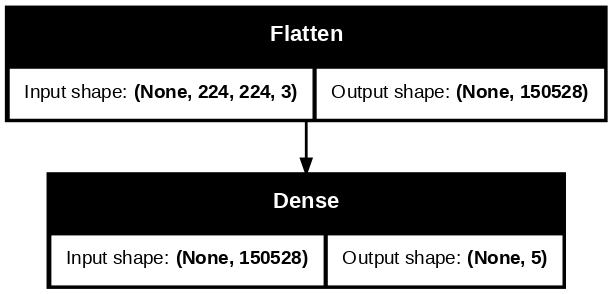

In [36]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))   # So that the label is the index into CLASS_NAMES array
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)


# Linear Model
model = tf.keras.Sequential([
              tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 除了 model.summary() 以外, TensorFlow 也提供了 plot_model() 的函數可以畫出模型架構
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=100)


# 小提醒：
#   新版的 TensorFlow 希望你把Input層也寫出來, 像這樣：
#     tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
#     tf.keras.layers.Flatten(), ...
#   而不是之前的寫法, 在第二層指定input_shape：
#     tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)), ...

上圖中的 None, 是因為輸入層會接收一個 batch 的影像, 所以 None 的值會等到接收到 N 張圖片之後才被決定為 N, 如此一來這個模型才可以適應各種 batch 大小。

In [37]:
# 開始訓練
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
    330/Unknown 201s 604ms/step - accuracy: 0.3113 - loss: 20.0487

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


330/330 ━━━━━━━━━━━━━━━━━━━━ 224s 672ms/step - accuracy: 0.3114 - loss: 20.0422 - val_accuracy: 0.4459 - val_loss: 13.2067
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 196s 476ms/step - accuracy: 0.4346 - loss: 13.4770 - val_accuracy: 0.4162 - val_loss: 18.3696
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 200s 470ms/step - accuracy: 0.4661 - loss: 12.1028 - val_accuracy: 0.3649 - val_loss: 27.6429
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 199s 463ms/step - accuracy: 0.4770 - loss: 12.2948 - val_accuracy: 0.3784 - val_loss: 22.7353
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 104s 315ms/step - accuracy: 0.5145 - loss: 12.7846 - val_accuracy: 0.4216 - val_loss: 19.1706
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 200s 490ms/step - accuracy: 0.5292 - loss: 11.8852 - val_accuracy: 0.3865 - val_loss: 29.9302
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 142s 308ms/step - accuracy: 0.5194 - loss: 14.4024 - val_accuracy: 0.4297 - val_loss: 23.5560
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 143s 310ms/step - accuracy: 0.573

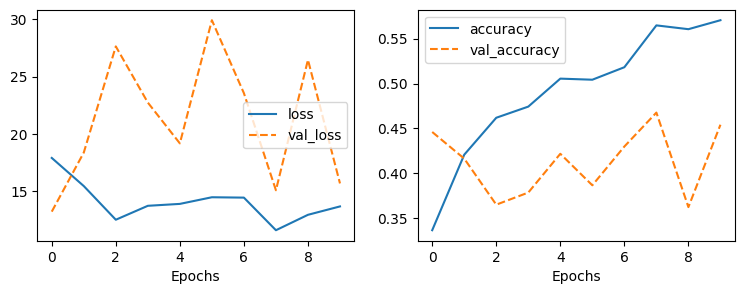

In [44]:
import matplotlib

matplotlib.rcParams.update({'font.size': 10})

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(9,3))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=10)

training_plot(['loss', 'accuracy'], history)

從上圖中可以看到, val_loss 仍然浮動非常之大, 且 val_accuracy 沒有上升的趨勢, 代表 model 並沒有太好的效果, 仍需要對其進行改進

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


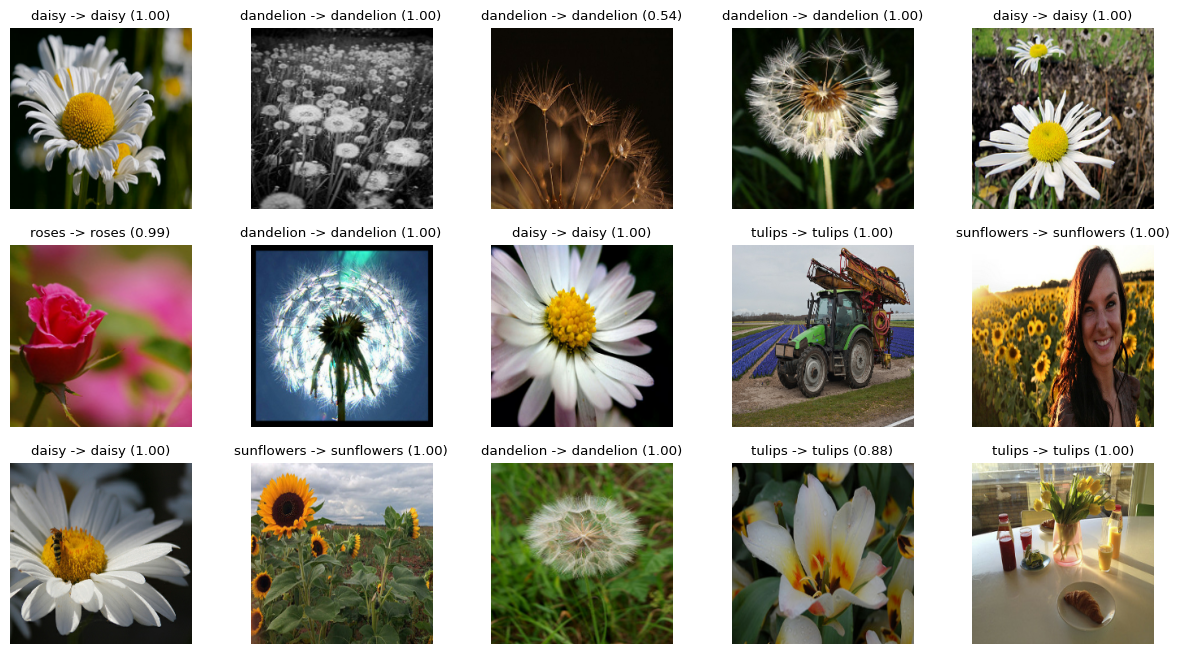

In [50]:
# 用 model.predict() 嘗試去對一些圖片進行預測
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 8})
  f, ax = plt.subplots(3, 5, figsize=(15,8))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]                  # pred 是個 (5) 的一維向量，代表五項花朵類別的信心值(logit)
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()    # 挑選信心值最大的當作預測結果
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

# 看看 model 在 training set 上的預測情況
plot_predictions("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv")

由上圖可見, model 在 training set 上的預測結果蠻準的, 幾乎都能在正確 label 有 1.00 的信心度

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


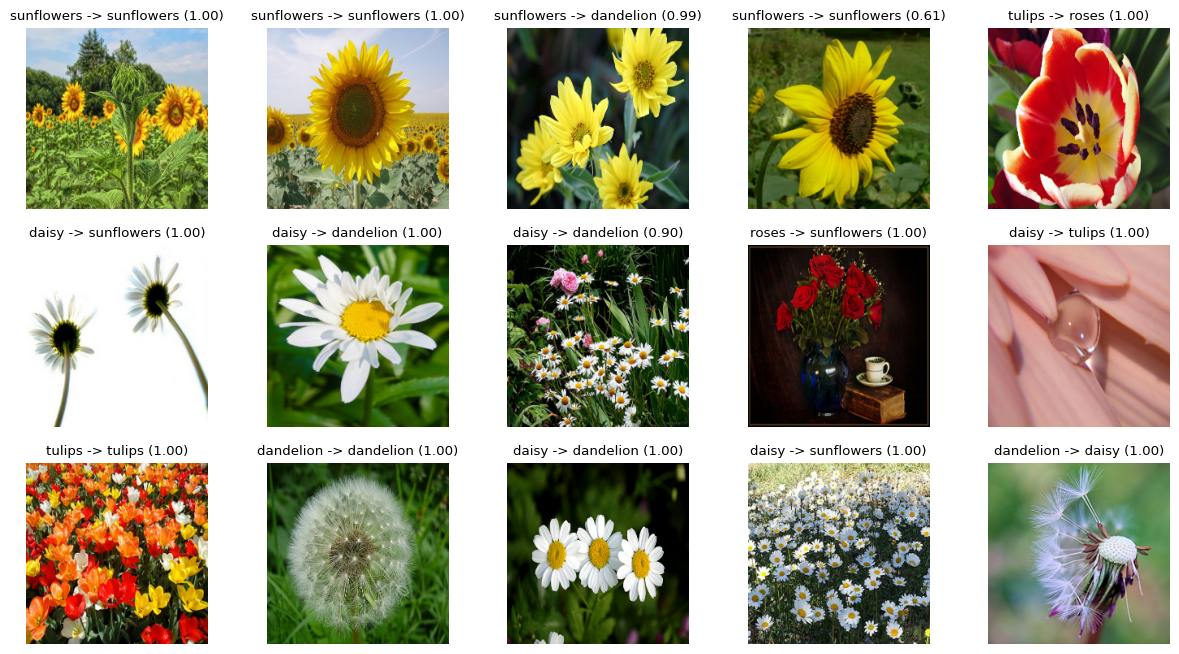

In [51]:
# 看看 model 在 evaluation set 上的預測情況
plot_predictions("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv")

由上圖可見, model 在 evaluation set 上反而準確率不佳, 時常有錯誤預測又信心度極高的情況發生 (例如: [0, 2], [0, 4], [1, 0], [1, 1] ...)

### Logit, Sigmoid, and Softmax
* `logit`: 事件發生比的對數, 即 `log(p / (1 - p))`。當 p 接近 0 時, logit 會接近負無限大; 當 p 接近 1 時, logit 則會接近正無限大。
* `sigmoid`: logit 的反函數, 即 `f(x) = 1 / (1 + e^(-x))`。
* `softmax`: 如果有 N 個互斥事件, 他們的 logit 為 Y_j, 則 softmax(Y_j) 代表`第 j 個事件發生的機率`。S(Y_j) = e^(-Y_j) / sigma(e^(-Y_j))。

In [ ]:
# softmax 會把事件轉成機率, 確保機率和為 1.0
# 下面有五個例子

import tensorflow as tf

inx = [
    [0,   0.09,  0.06,  0.85,    0],
    [0.1,  0.1,   0.7,   0.1,  0.1],
    [0,    0.2,   0.4,   0.2,    0],
    [0.1,  0.1,   0.4,   0.5,  0.1],
    [0.2,  0.2,   0.8,   0.2,  0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print('Probability:', prob.numpy(), '; Softmax:', softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()

---
# **Approach \#3: 再添加一層 non-linear layer**
再加入一層 hidden layer, 並且選擇非線性的 activation function (例如 relu)

##### Setup

In [1]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##### 訓練模型

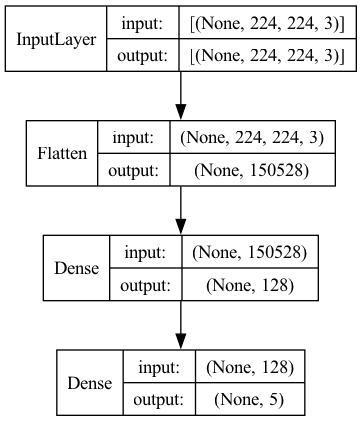

In [3]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [4]:
# 因為 model 的輸出已經是 softmax, 不是 logit, 所以 from_logits=False
# loss 使用 SparseCategoricalCrossentropy 是因為 一張圖片只有單一類別
# 如果是一張圖片屬於多個類別, 應該用 CategoricalCrossentropy
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 255s 2s/step - loss: 11.6070 - accuracy: 0.3109 - val_loss: 4.3289 - val_accuracy: 0.3676
Epoch 2/10
104/104 [==============================] - 267s 3s/step - loss: 3.1332 - accuracy: 0.3761 - val_loss: 3.3380 - val_accuracy: 0.3676
Epoch 3/10
104/104 [==============================] - 254s 2s/step - loss: 1.9098 - accuracy: 0.3870 - val_loss: 1.5384 - val_accuracy: 0.2027
Epoch 4/10
104/104 [==============================] - 257s 2s/step - loss: 1.5145 - accuracy: 0.2894 - val_loss: 1.5418 - val_accuracy: 0.3459
Epoch 5/10
104/104 [==============================] - 311s 3s/step - loss: 1.4738 - accuracy: 0.3397 - val_loss: 1.4210 - val_accuracy: 0.2838
Epoch 6/10
104/104 [==============================] - 264s 3s/step - loss: 1.5108 - accuracy: 0.2906 - val_loss: 1.4866 - val_accuracy: 0.2216
Epoch 7/10
104/104 [==============================] - 248s 2s/step - loss: 1.5086 - accuracy: 0.2770 - val_loss: 1.4898 - val_accuracy: 0.308

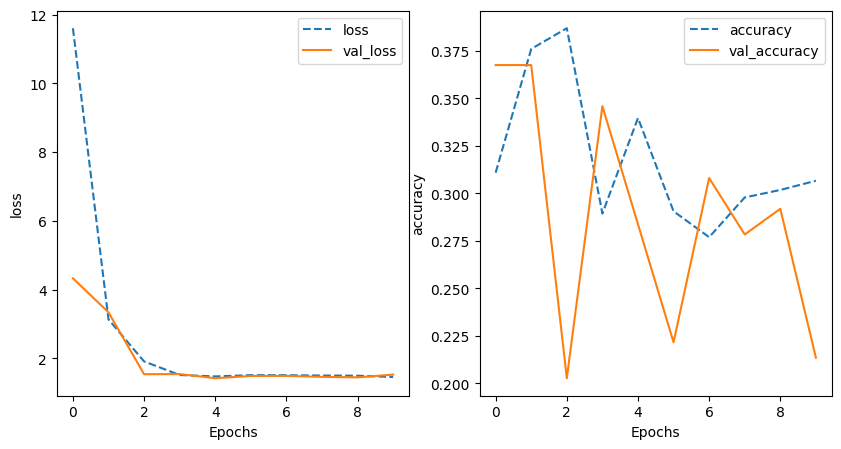

In [5]:
# 來看看這 10 個 epoch 訓練中, loss & accuracy 的變化
training_plot(['loss', 'accuracy'], history)

由上圖可以看出, loss 的變化很不錯, 但是 accuracy 仍然不佳, 所以目前的 neural network 架構也不夠好

### **None-Linear Activation Function**

* `Sigmoid`：早期常用的啟動函數，輸出範圍為 (0, 1)，模擬神經元激發的機制，但在`接近極值時梯度變小`，容易導致`學習速度慢`與`梯度消失`問題。
* `ReLU`：目前最常見的啟動函數，運算快速，正區域梯度恒定，有助於快速收斂。但在`輸入小於 0 的區域輸出為 0`，可能導致 `dead neuron` 問題。
* `ELU`：改良版的 ReLU，在`輸入 < 0 的部分輸出小的負值`，減少 dead neuron 問題，但需要額外的`指數運算，成本較高`。
* `Leaky ReLU`：ReLU 的變形版本，在`輸入 < 0 的部分保留一小部分負斜率`（如 0.01x），可避免神經元死掉的問題，`常被專業人士優先採用`。

### **Learning Rate**
* lr 會影響梯度下降時的每一步大小, 如果太大可能會錯過 global minimum, 但如果太小可能會卡在 local minimum
* 使用更小的 lr 進行訓練, accuracy 的曲線浮動程度就不會像上面那麼大, 而是變得更平滑了
* Adam Optimizer 的 default lr = 0.001

### **Regularization (正則化)**
* 透過改變 loss, 對權重值本身施加懲罰, 來減少 overfitting 發生的機會
* `L1 Regularization Term`: loss = cross_entropy + sigma(|w_i|)
* `L2 Regularization Term`: loss = cross_entropy + sigma((w_i ^ 2))
* 通常來說, L1 比較精簡, 但 L2 可以更好的限制 overfitting

### **Early Stopping**
* 驗證準確度停止上升時就中止訓練
* 注意：要再調整完 lr 跟 regularization 後再加入 early stopping, 否則會因為訓練曲線仍然起伏不定而錯誤地提前終止訓練

### **調整 Hyperparameter**
使用 Keras Tuner 來找尋超參數的最佳值

In [7]:
import kerastuner as kt

# parameterize to the values in the previous cell
def build_model(hp):
  lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')       # lr 會是 0.1 ~ 0.0001 之間的浮點數
  l1 = 0
  l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])  # l2 會是 [0, 0.1, 0.01, 0.001, 0.0001] 其中之一 
  num_hidden = hp.Int('num_hidden', 32, 256, 32)              # num_hidden 會是 32, 64, 96, 128, 160, 192, 224, 256 其中之一

  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  return model

batch_size = 32
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(batch_size)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(32) # this doesn't matter

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'), 
    max_trials=10,
    num_initial_points=2, 
    overwrite=False) # True to start afresh.

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

# topN: 列出前多少名的組合
topN = 2
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

Trial 4 Complete [00h 20m 50s]
val_accuracy: 0.4675675630569458

Best val_accuracy So Far: 0.4675675630569458
Total elapsed time: 01h 04m 09s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |lrate
0                 |0.1               |l2
160               |256               |num_hidden



Epoch 1/5
     10/Unknown - 23s 2s/step - loss: 8.7220 - accuracy: 0.2344

KeyboardInterrupt: 

---
# **Approach \#4: DNN(Deep Neural Network, 多層神經網路)**
具有多個隱藏層的神經網路

In [ ]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # 增加多層的 Dense Layer
  # 這裡的 num_hidden 只有兩項, 所以等於是添加兩層的 Dense layer 而已, 如果有需要可以繼續增加
  layers = [
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)), 
    tf.keras.layers.Flatten(name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.summary()
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

### **Dropout**
* 每次訓練迭代中, dropout 層會從網路中隨機丟棄不同的神經元 (實務上, 被丟棄的神經元之輸出會被設置為0, 他們不會參與loss的計算, 也不會更新權重)
* Dropout 背後之原理：神經網路的自由度相當高, 以至於某一層發展出不良行為是完全有可能的, 而下一層也可能對其進行修復。在使用 dropout 後, 修復問題的神經元可能被 drop 掉, 導致不良行為變得明顯, 讓權重可以朝著更好的方向發展。

### **Batch Normalization(批次正規化)**
* 見 p.48 的圖, 每個隱藏層的輸出不一定會落在適合 sigmoid 的範圍內, 所以我們必須想辦法調整輸出的數值分佈！
* 一般的正規化, 是透過`減去平均值並除以標準差的方式`進行正規化, 但如果是完全置中且常態分佈的的資料下, 所有神經元都將具有相同的行為。
* 所以 batch normalization 透過兩個可以學習的參數 scale 和 center 兩個值來進行正規化, output = (input - center) / scale
* 所以就是：`為每個神經元會額外添加2個可以學習的參數 scale & center`, 這樣每個神經元就都會有不同的 centering 與 rescaling 了！

* 所以, 我們會在`activation function 之前先使用 batch normalization`
* 如果層中本身就有 bias (例如 Dense layer), batch normalization 中就不需 center (center=False); 反之則需要
* 如果使用的是 scale-invarient(放大也不會改變形狀) 的 activation function (例如 ReLU, 而 Sigmoid 就不是), 則可以設定 scale=False

In [ ]:
# 以下只是範例, 說明加入 batch norm 跟 dropout 的樣子大致會如下所示：
# move activation to come after batchnorm

layers.extend([
    tf.keras.layers.Dense(nodes, kernel_regularizer=regularizer, name='hidden_dense_{}'.format(hno)),
    tf.keras.layers.BatchNormalization(scale=False,    # 因為下面的 activation function 是 ReLU, 不會因為 rescale 改變形狀
                                        center=False,  # 因為 Dense layer 本身就有 bias (output = WX + b)
                                        name='batchnorm_dense_{}'.format(hno)),
    tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
    tf.keras.layers.Dropout(rate=dropout_prob, name='dropout_dense_{}'.format(hno)),                         
])

---
## **結論**
* 上述方法是將 pixels 當作是獨立輸入, 但這樣利用 `fully-connected layer` 在影像上的表現並不好, 因為他們並沒有利用到`相鄰像素會高度相關`的特性！
* 相鄰的像素可以一起合作以建立形狀 (例如直線與弧形), 而這些形狀又可以一起合作以建立物件的可識別部分 (例如花的莖與花瓣)
* 所以 接下來我們將透過一些`會利用影像特殊屬性的模型架構與技術`來解決這個問題